In [1]:
import numpy as np
import pyemma
import msmtools.estimation as est
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyemma.plots as mplt
import h5py
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
from MSMRD.visualization import createDensityData
%load_ext Cython

In [2]:
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

234


/home/mi/dibakma/miniconda2/lib/python2.7/site-packages/MSMRD-0.1-py2.7-linux-x86_64.egg/MSMRD/discretization/spherePartition.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


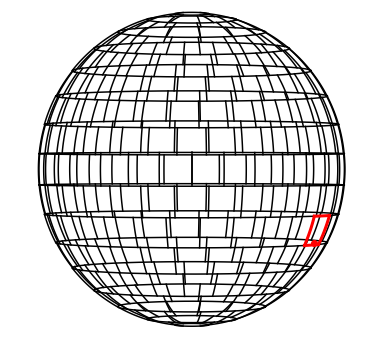

In [3]:
# Testing correct state output mini script (use along with testSpherePrtitionPlot NB)
# Consistent with test
numPartitions = 322
boxSize = 6
innerMSMrad = 2.5
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize, innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
coord = np.array([3.4,-2,-2]) # norm larger than innerMSMrad (boxSize/2)
sphereState = discretizer.getStatePy(coord,-1) - (len(minima) - 1)

# Call function to plot state and coordinate in spherical partition
print sphereState
plotPartitionedSphere(numPartitions = numPartitions, plotState=sphereState, coord=coord)

In [ ]:
%%time
numfiles = 200
# Load partitions, boxsize and minimas
numPartitions = 322
boxSize = 6
innerMSMrad = 2.5
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])

# Extract trajectories from file using asym2Dtraj class
# fname = '../data/asym3D/3DasymTrajs_pBox5_sf2_R4_RT1e7_dt001_si10_' # old data with bug in potential
# fname = '../data/asym3D/3DasymTrajs_pbox5_RT1e7_sf2.0_dt0.001_si10_run_'
fname = '../data/asym3D/3DasymTrajs_pbox6_RT1e7_sf2.0_dt0.001_si10_run_'
dimension = 3
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize,innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
trajs = []
dTrajs = []
#fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
samplingInterval = 10 # in the original computation
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    #fullDTrajs.append(discretizer.getdTrajs([traj]))
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj
    #trajs.append(traj) # Need to pass to create density data for visit visualization

5.0% done
10.0% done
15.0% done
20.0% done
25.0% done
30.0% done
35.0% done
40.0% done
45.0% done
50.0% done
55.0% done
60.0% done
65.0% done


79800


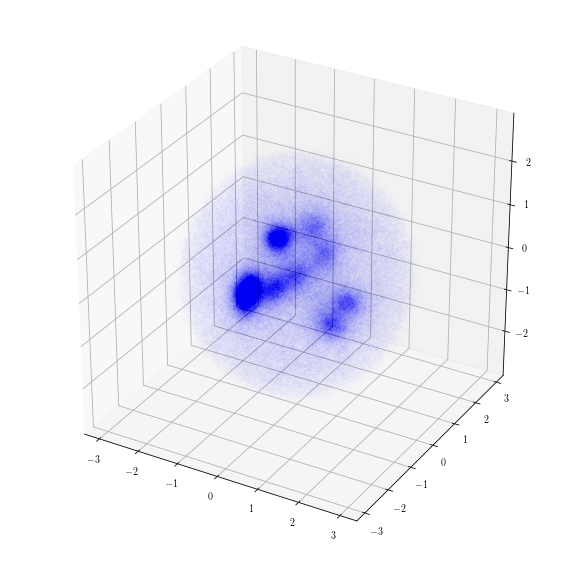

In [5]:
# visualize trunc trajs
def plotTrajs(trajs,numTrajs):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d') 
    i=0
    print(len(trajs))
    for traj in trajs:
        trajx = []
        trajy = []
        trajz = []
        for i in range(len(traj)):
            trajx.append(traj[i][0])
            trajy.append(traj[i][1])
            trajz.append(traj[i][2])
        #ax.plot(trajx,trajy,trajz,'.')
        ax.plot(trajx,trajy,trajz,'b-', lw=0.0002)
        i += 1
        if i > numTrajs:
            break
            
plotTrajs(truncTrajs,100000)

In [5]:
its = pyemma.msm.its(dTrajs, lags = 20)

# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

KeyboardInterrupt: 

In [ ]:
MSMlag = 10
M = pyemma.msm.estimate_markov_model(dTrajs, lag=MSMlag)

In [ ]:
# truncate transition matrix such that only transitions withing the inner states are allowed
Tmatrix= np.copy(M.transition_matrix[:len(minima),:len(minima)])
for i in range(len(minima)):
    Tmatrix[i,:] /= np.sum(Tmatrix[i,:])

In [118]:
# Get exit/entry lookup tables
%time
# CALL WITH dTruncTrajs or dTrajs, see function in trajectoryTools.pyx
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.2 µs


In [111]:
for i in range(len(dTruncTrajs)):
    if np.any(dTruncTrajs[i] < 0):
        print 'found one'
        break

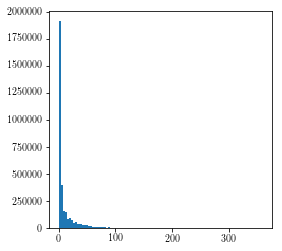

In [82]:
hist = plt.hist(entryTimes, bins=100)

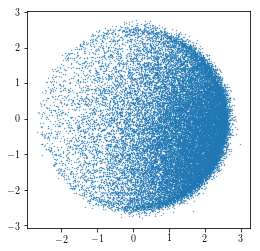

In [59]:
state = 8
plt.scatter(np.array(exitPositions[state])[:,0], np.array(exitPositions[state])[:,1], 0.1)

In [33]:
%time
exitTrajs = []
for i in range(9):
    exitTrajs += (transitionTrajs[i][9])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


In [119]:
def implied_timescales(lag):
    fullCount = est.count_matrix(dTrajs, lag)
    exitCounts = est.count_matrix(exitTrajs, lag)
    finalCountMatrix = 1. * fullCount
    for i in range(9):
        finalCountMatrix[i,i] -= exitCounts[i,i]
    tmatrixFull = est.transition_matrix(fullCount)
    tmatrix = est.transition_matrix(finalCountMatrix).todense()
    treduced = np.copy(tmatrix[:9,:9])
    for i in range(9):
        treduced[i,:] /= np.sum(treduced[i,:])
    MSM = pyemma.msm.markov_model(treduced)
    return MSM.timescales()

[[ 141.07674827  110.88580221   69.1225998    41.11950715   37.30325762
    35.11369036   33.37565629   23.68554066]
 [ 136.27434236  106.29134695   64.42967611   36.920435     32.94392679
    30.87711657   29.24424419   20.11861324]
 [ 132.74221346  103.4281553    61.20749152   34.53159371   30.31999272
    28.58050476   27.07091416   18.63460517]
 [ 130.60718151  101.94652026   59.26292463   33.07365837   28.52830485
    27.00349804   25.84737477   17.69128161]
 [ 129.54681513  101.29853018   58.15226726   32.06530184   27.175241
    25.6310692    25.01666805   16.83830037]
 [ 129.1632721   101.15440391   57.56195798   31.28599336   26.08501139
    24.26845759   24.26845759   15.81738691]
 [ 129.19392226  101.27624338   57.34720881   30.65522643   25.25570713
    23.48500832   22.66049324   14.30501378]
 [ 129.5258985   101.57878835   57.40331506   30.15577331   24.70760509
    22.34913944   20.67869696    7.49309509]
 [ 129.94883811  101.98789526   57.61903219   29.71801907   24.335

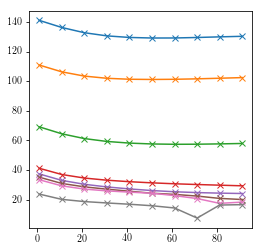

In [120]:
timescales = []
lagtimes = range(1, 100, 10)
for lag in lagtimes:
    timescales.append(implied_timescales(lag)*lag)
timescales = np.array(timescales)
for i in range(8):
    plt.plot(lagtimes, timescales[:,i], '-x')
#plt.xlabel('lag-time')
#plt.ylabel('timescale')
#plt.title('implied timescales')
#plt.savefig('../Report/figs/periodicModel/impliedTimescales.pdf')
print timescales

In [ ]:
fullCount = est.count_matrix(dTrajs, 20)
exitCounts = est.count_matrix(exitTrajs, 20)

In [123]:
finalCountMatrix = 1. * fullCount
for i in range(9):
    finalCountMatrix[i,i] -= exitCounts[i,i]

In [124]:
tmatrix = est.transition_matrix(finalCountMatrix).todense()
treduced = np.copy(tmatrix[:9,:9])
for i in range(9):
    treduced[i,:] /= np.sum(treduced[i,:])
for i in range(9):
    print (treduced[i,i])

0.750431685644
0.608328526034
0.698551482466
0.639250057779
0.547828033883
0.691805577197
0.590577900606
0.574963638216
0.709763242703


In [125]:
tmatrixFull = est.transition_matrix(fullCount).todense()
treducedFull = np.copy(tmatrixFull[:9,:9])
for i in range(9):
    treducedFull[i,:] /= np.sum(treducedFull[i,:])
for i in range(9):
    print (treducedFull[i,i])

0.824092651924
0.716288211728
0.809060495735
0.70312709983
0.610806939432
0.793899783286
0.658678170569
0.652161103307
0.820943251188


In [126]:
MSM = pyemma.msm.markov_model(treduced)
MSM.mfpt([0], [1])*0.2

5.7960261788594805

In [106]:
MSM = pyemma.msm.markov_model(treduced)
MSM.mfpt([0], [1])*0.1

1.6451071338383756

In [ ]:
plt.matshow(treducedFull - treduced)
plt.colorbar()

In [127]:
# Calculate exit probabilities for each of the inner states
exitProbs = np.zeros(len(minima))
for i in range(len(minima)):
    outgoingTrajs = 0
    for j in range(10): ## WHY 10 and not 9 (len(minima))?
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][len(minima)])/float(outgoingTrajs)
print exitProbs

[ 0.31588893  0.29035686  0.42675553  0.17317082  0.10593895  0.3763791
  0.1641954   0.16467876  0.43560344]


KeyboardInterrupt: 

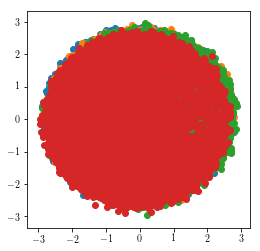

In [128]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
#for i in range(9):
    #print np.sort(exitTimes[i])

In [129]:
# Partition MSM entry trajectories into discrete regions in the sphere 
spherePartitionsForLookUp = 1*numPartitions
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStart[:], axis=1)
phis_coords = np.arccos(entryTrajsStart[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStart[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEnd[j])
        sortedEntryTrajsEnd.append(sortedEnds)
        

In [130]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel3D(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, numPartitions):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.numPartitions = numPartitions

In [131]:
model = truncTrajsModel3D(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.1, treduced, numPartitions)

In [132]:
import pickle
pickle.dump(model, open('../data/models/asym3D/periodicModel_lag20_200files_322partitions.p', 'wa'))

In [ ]:
1+1

In [ ]:
createDensityData(trajs,filename="test3DdensityData_Sf2_200files")

In [ ]:
MSMradius = 2.
X = np.arange(-MSMradius, MSMradius, 0.05)
Y = np.arange(-MSMradius, MSMradius, 0.05)
Z = np.arange(-MSMradius, MSMradius, 0.05)
Zfull = np.zeros([X.shape[0]-1, Y.shape[0]-1, Z.shape[0]-1])
for trj in trajs:
    hist = np.histogramdd(traj, bins = (X, Y, Z))
    Zfull += hist[0]